In [105]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')

In [107]:
def get_apps_dataset():
  app_train = pd.read_csv('data/application_train.csv')
  app_test = pd.read_csv('data/application_test.csv')

  return pd.concat([app_train, app_test])

apps = get_apps_dataset()

In [108]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [109]:
prev = pd.read_csv('data/previous_application.csv')

prev.shape, apps.shape

((1670214, 37), (356255, 122))

In [110]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
print(prev_app_outer.shape)
prev_app_outer.head()

(1687612, 38)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,_merge
0,2030495.0,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15.0,...,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,both
1,1696966.0,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18.0,...,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,both
2,2154916.0,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14.0,...,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,both
3,2802425.0,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11.0,...,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,both
4,1536272.0,108129,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9.0,...,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,both


In [112]:
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

In [113]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [114]:
prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count()

SK_ID_CURR
100001    1
100002    1
100003    3
100004    1
100005    2
         ..
456251    1
456252    1
456253    2
456254    2
456255    8
Name: SK_ID_CURR, Length: 338857, dtype: int64

In [115]:
prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

4.928964135313716

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SK_ID_CURR'>

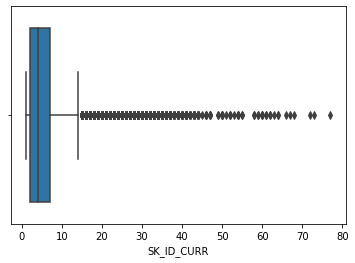

In [116]:
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count())

In [117]:
def show_hist_by_target(df, columns):
  cond_0 = df['TARGET'] == 0
  cond_1 = df['TARGET'] == 1

  for column in columns:
    print('column name: ', column)
    fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
    sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0]) # takes long time to create violinplot
    sns.distplot(df[cond_0][column], label='0', color='blue', ax=axs[0][1])
    sns.distplot(df[cond_1][column], label='1', color='red', ax=axs[0][1])


In [118]:
app_prev = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape

(1670214, 38)

In [119]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
num_columns

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

column name:  AMT_ANNUITY


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  AMT_APPLICATION


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  AMT_CREDIT


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  AMT_DOWN_PAYMENT


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  AMT_GOODS_PRICE


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  HOUR_APPR_PROCESS_START


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  NFLAG_LAST_APPL_IN_DAY


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  RATE_DOWN_PAYMENT


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  RATE_INTEREST_PRIMARY


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  RATE_INTEREST_PRIVILEGED


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_DECISION


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  SELLERPLACE_AREA


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  CNT_PAYMENT


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_FIRST_DRAWING


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_FIRST_DUE


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_LAST_DUE_1ST_VERSION


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_LAST_DUE


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  DAYS_TERMINATION


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column name:  NFLAG_INSURED_ON_APPROVAL


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


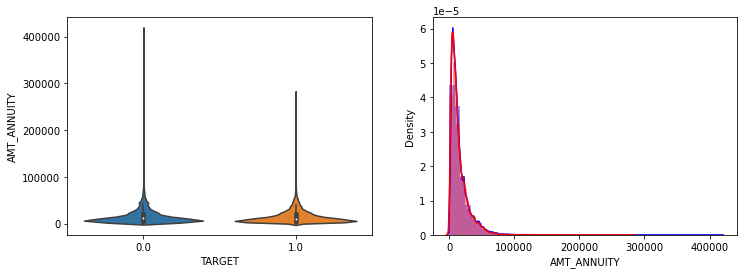

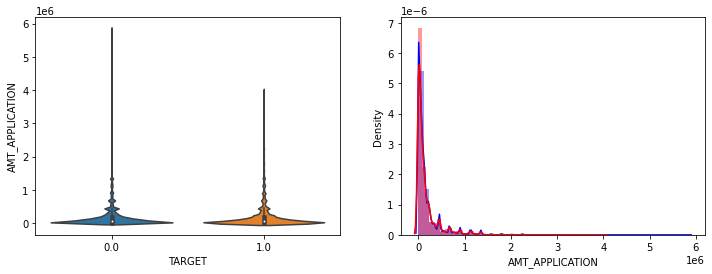

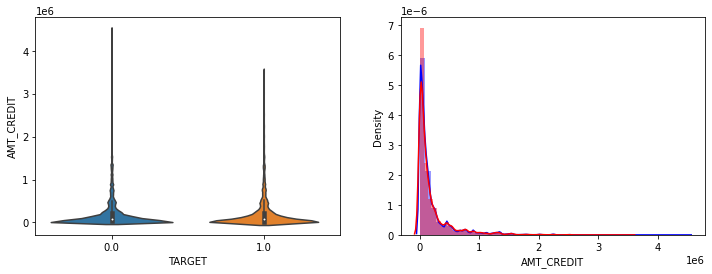

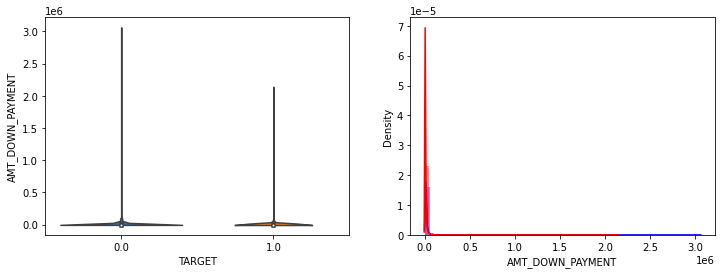

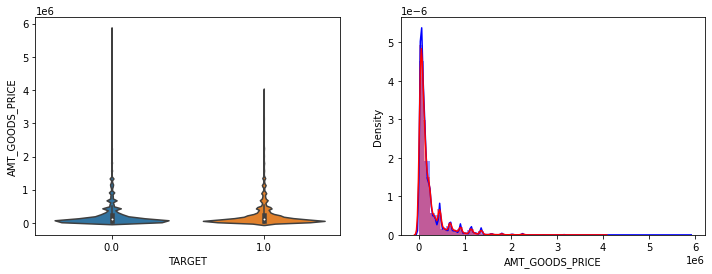

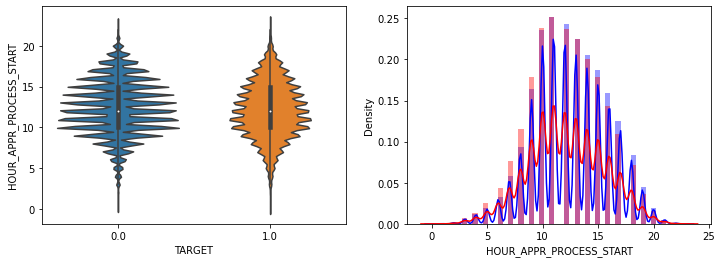

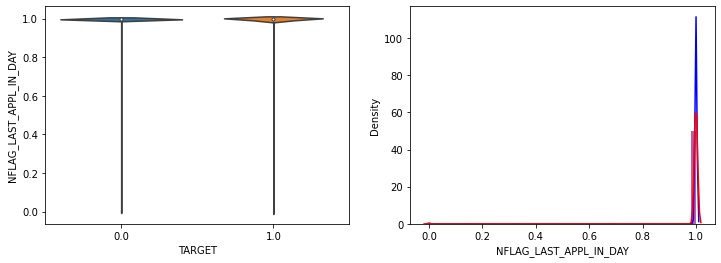

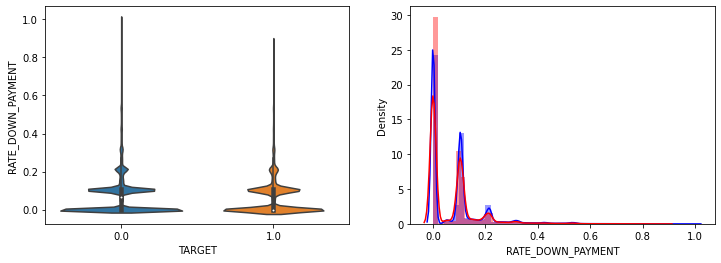

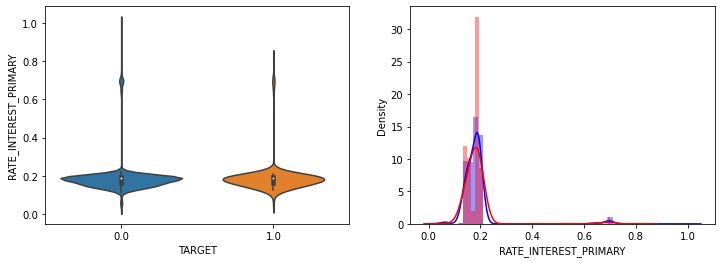

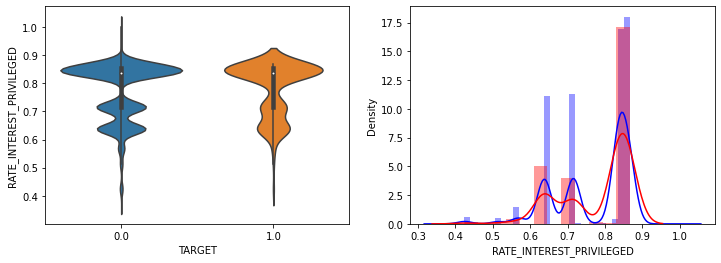

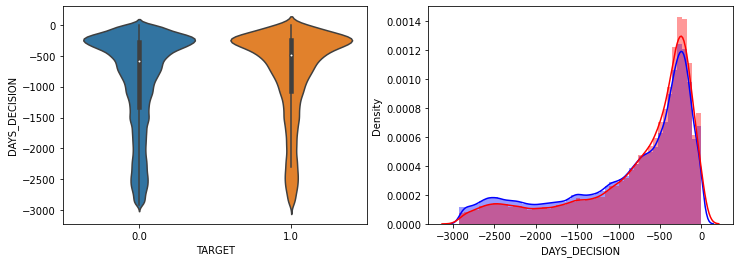

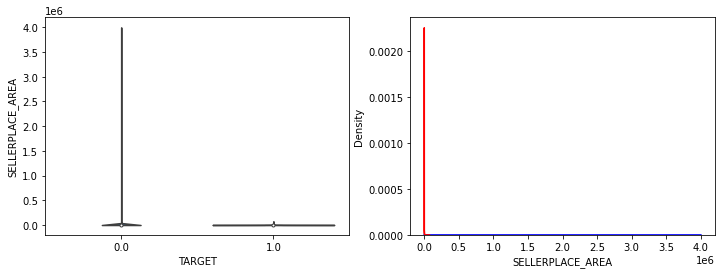

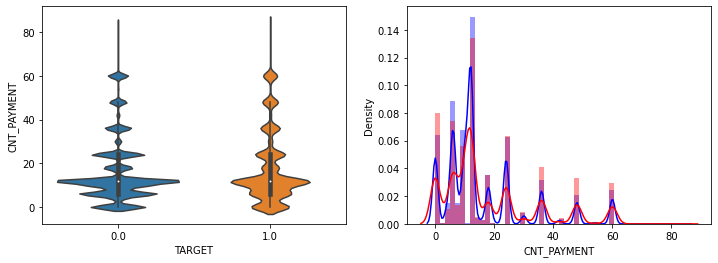

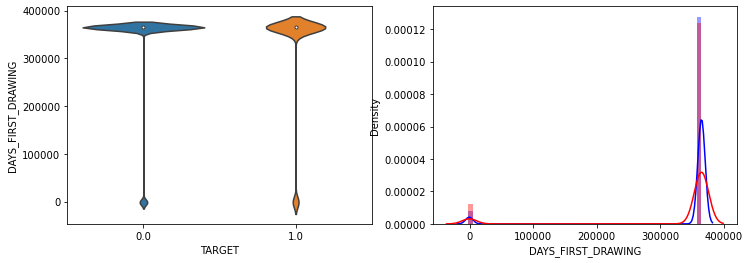

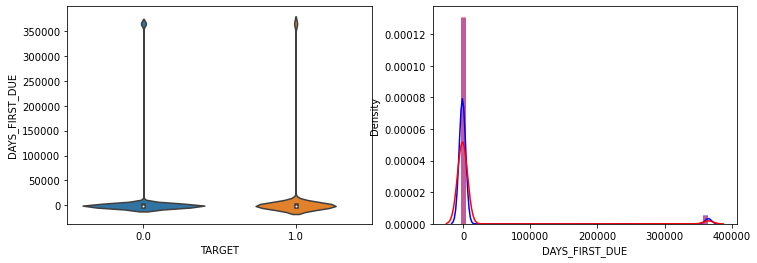

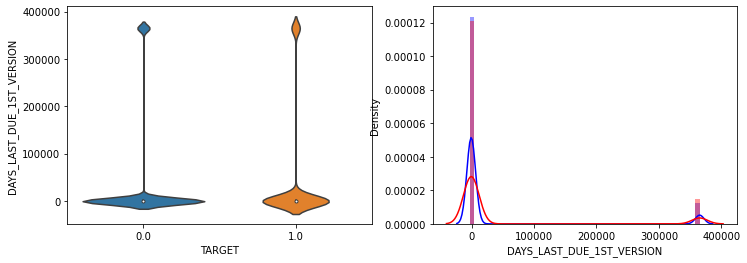

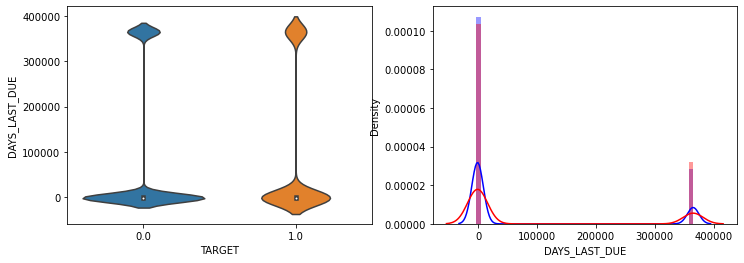

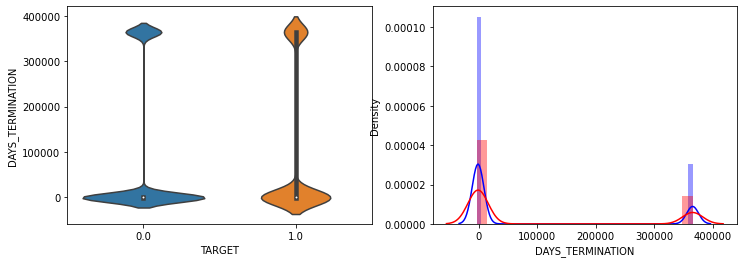

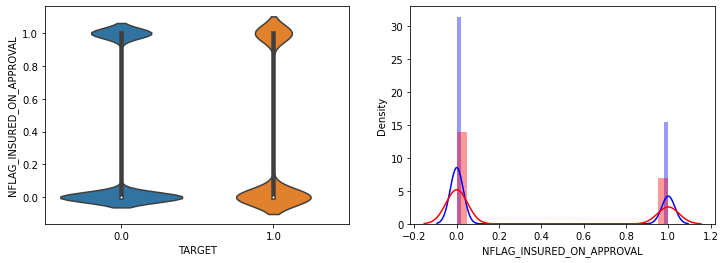

In [120]:
show_hist_by_target(app_prev, num_columns)

In [121]:
def show_category_by_target(df, columns):
  for column in columns:
    print('column name: ', column)
    chart = sns.catplot(x=column, col='TARGET', data=df, kind='count')
    chart.set_xticklabels(rotation=65)

column name:  NAME_CONTRACT_TYPE
column name:  WEEKDAY_APPR_PROCESS_START
column name:  FLAG_LAST_APPL_PER_CONTRACT
column name:  NAME_CASH_LOAN_PURPOSE
column name:  NAME_CONTRACT_STATUS
column name:  NAME_PAYMENT_TYPE
column name:  CODE_REJECT_REASON
column name:  NAME_TYPE_SUITE
column name:  NAME_CLIENT_TYPE
column name:  NAME_GOODS_CATEGORY
column name:  NAME_PORTFOLIO
column name:  NAME_PRODUCT_TYPE
column name:  CHANNEL_TYPE
column name:  NAME_SELLER_INDUSTRY
column name:  NAME_YIELD_GROUP
column name:  PRODUCT_COMBINATION


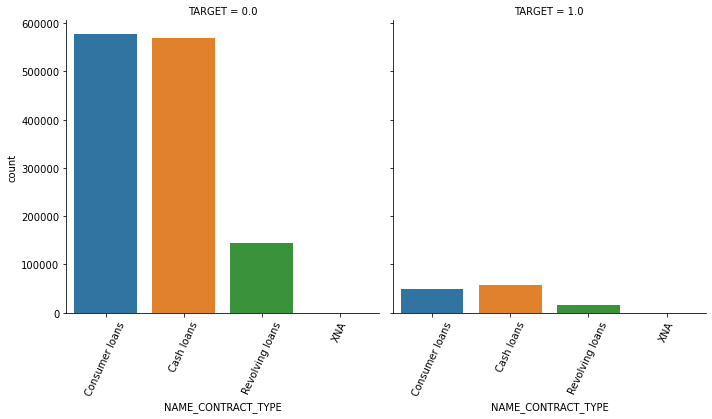

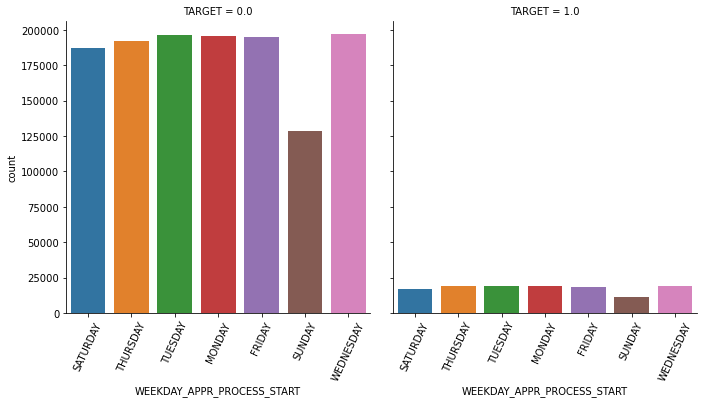

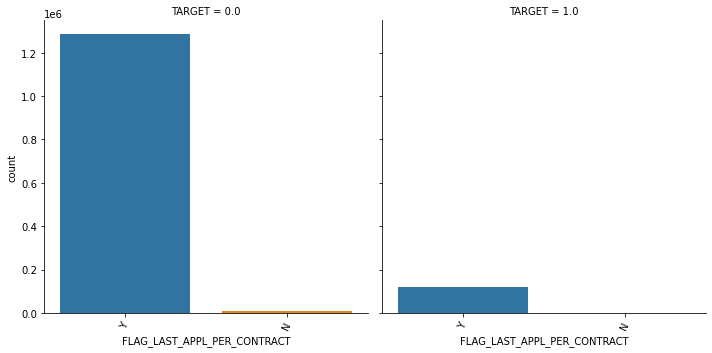

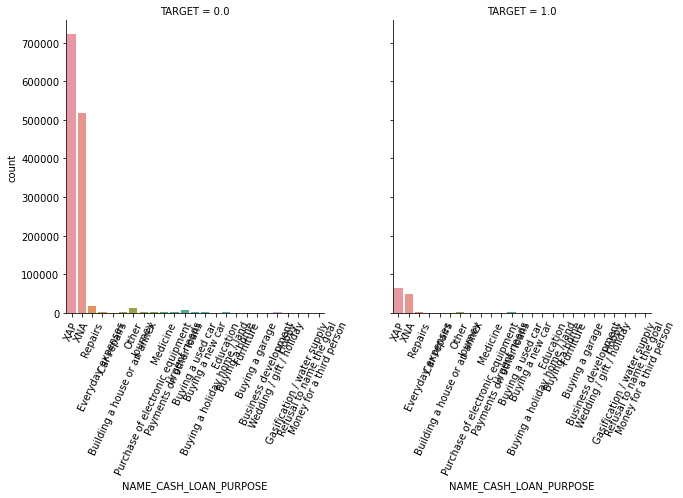

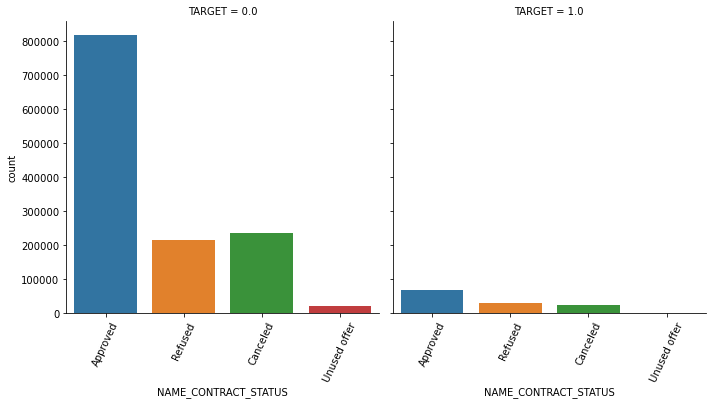

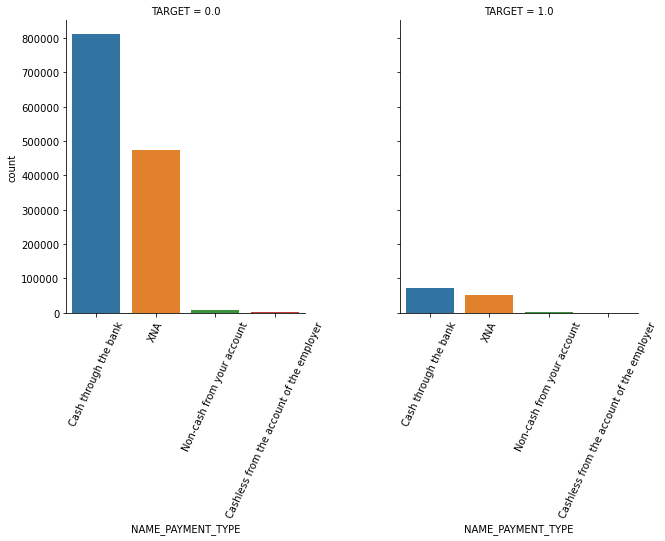

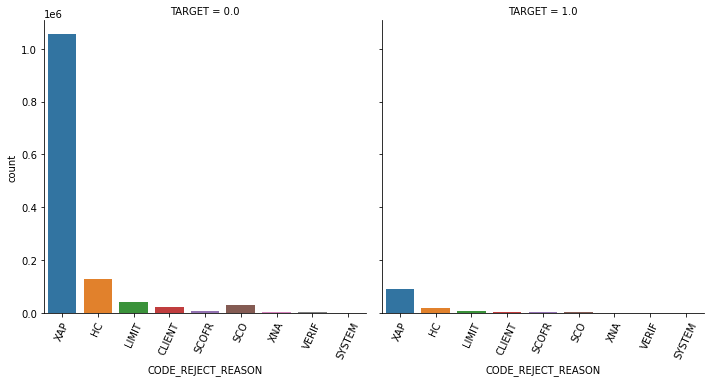

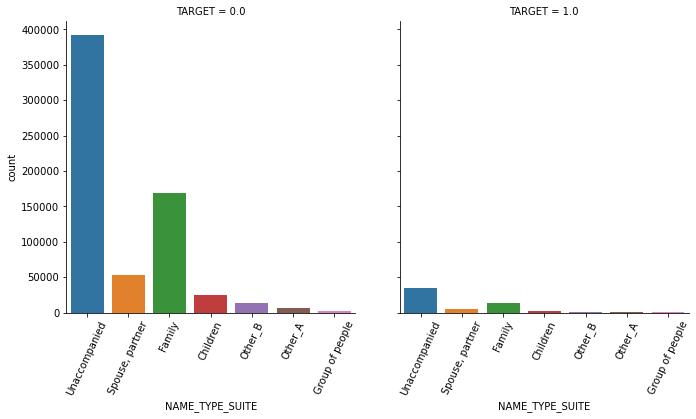

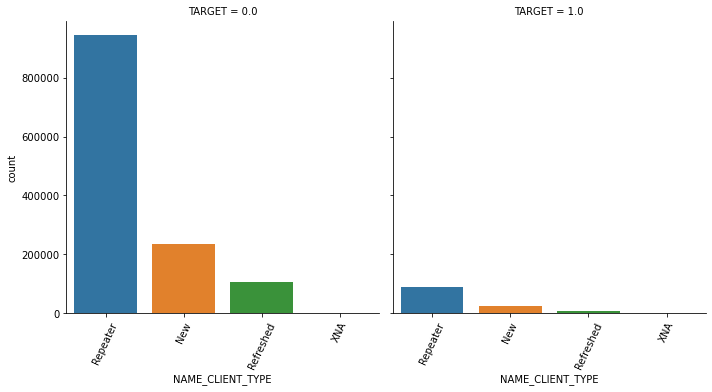

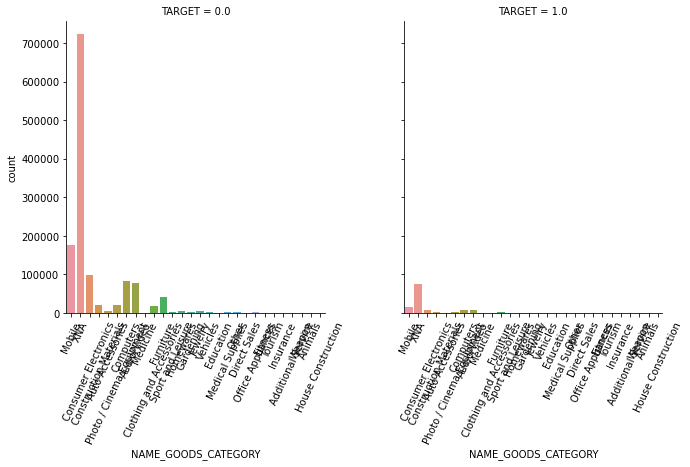

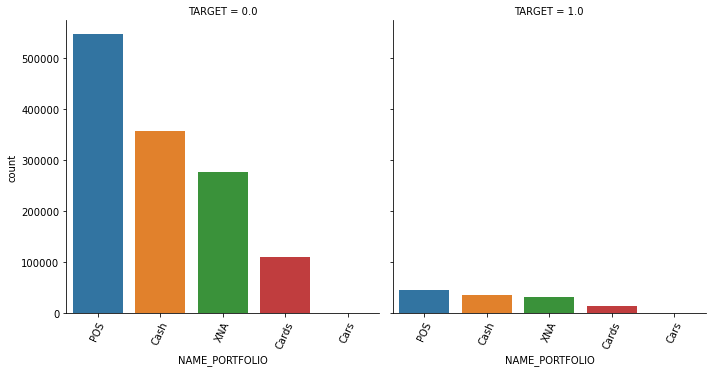

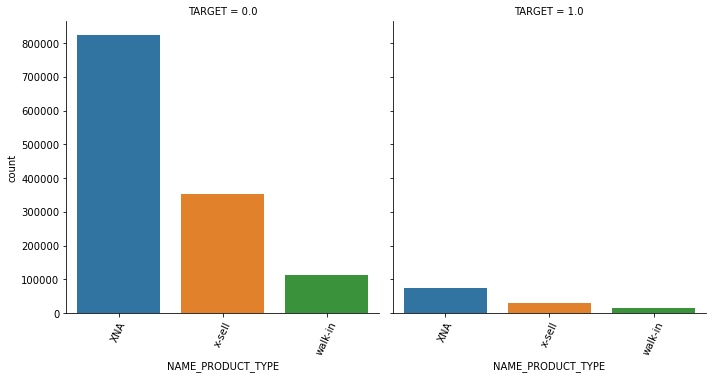

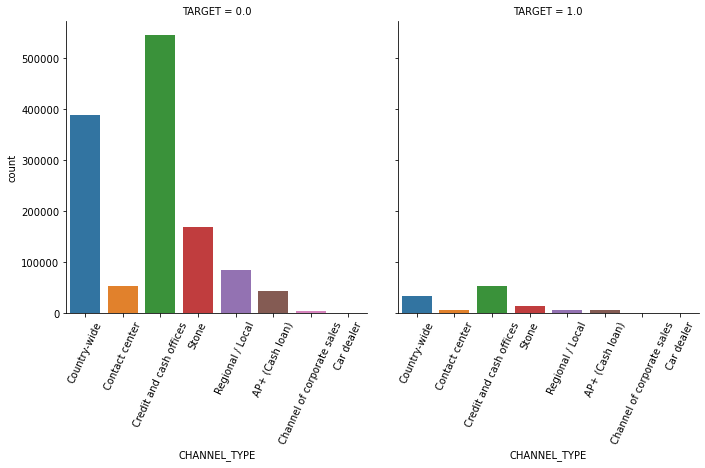

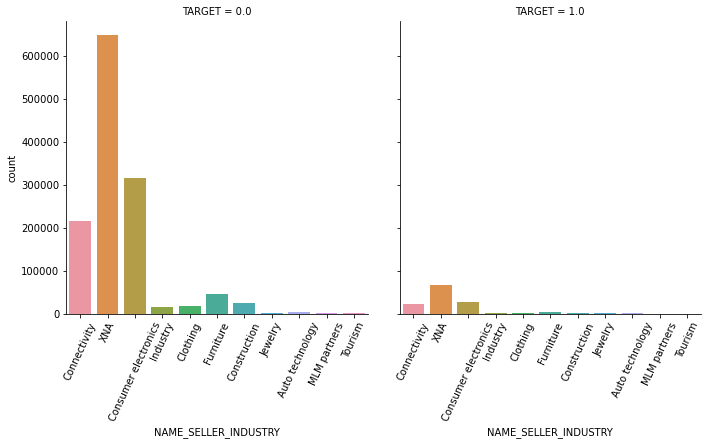

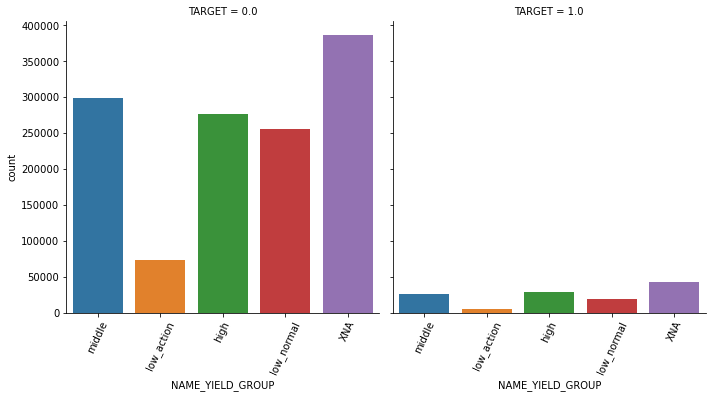

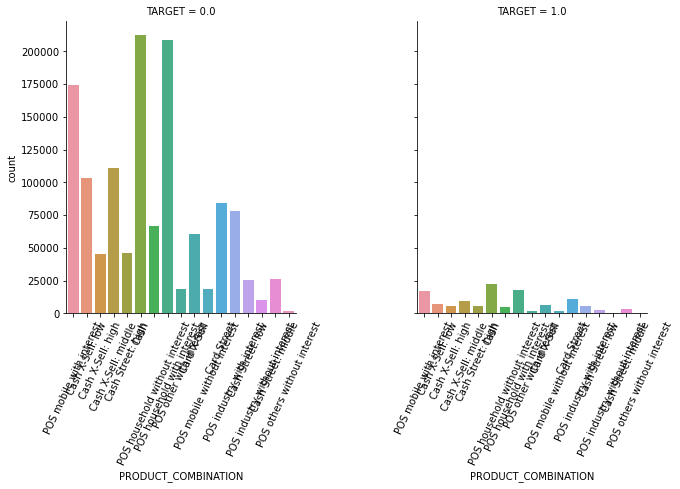

In [122]:
object_columns = app_prev.dtypes[app_prev.dtypes == 'object'].index.tolist()
show_category_by_target(app_prev, object_columns)

In [123]:
prev_group = prev.groupby('SK_ID_CURR')
prev_agg = pd.DataFrame()

In [124]:
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg['CNT'].head()

SK_ID_CURR
100001    1
100002    1
100003    3
100004    1
100005    2
Name: CNT, dtype: int64

In [125]:
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean()
prev_agg.head()

,CNT,AVG_CREDIT
SK_ID_CURR,,
100001,1,23787.00
100002,1,179055.00
100003,3,484191.00
100004,1,20106.00
100005,2,20076.75


In [126]:
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()
prev_agg.head()

,CNT,AVG_CREDIT,MAX_CREDIT
SK_ID_CURR,,,
100001,1,23787.00,23787.0
100002,1,179055.00,179055.0
100003,3,484191.00,1035882.0
100004,1,20106.00,20106.0
100005,2,20076.75,40153.5


In [127]:
prev_agg['MIN_CREDIT'] = prev_group['AMT_CREDIT'].min()
prev_agg.head()

,CNT,AVG_CREDIT,MAX_CREDIT,MIN_CREDIT
SK_ID_CURR,,,,
100001,1,23787.00,23787.0,23787.0
100002,1,179055.00,179055.0,179055.0
100003,3,484191.00,1035882.0,68053.5
100004,1,20106.00,20106.0,20106.0
100005,2,20076.75,40153.5,0.0


In [128]:
prev_agg.reset_index()

,SK_ID_CURR,CNT,AVG_CREDIT,MAX_CREDIT,MIN_CREDIT
0,100001,1,23787.00,23787.0,23787.0
1,100002,1,179055.00,179055.0,179055.0
2,100003,3,484191.00,1035882.0,68053.5
3,100004,1,20106.00,20106.0,20106.0
4,100005,2,20076.75,40153.5,0.0
...,...,...,...,...,...
338852,456251,1,40455.00,40455.0,40455.0
338853,456252,1,56821.50,56821.5,56821.5
338854,456253,2,20625.75,27306.0,13945.5
338855,456254,2,134439.75,247423.5,21456.0


In [129]:
prev_group = prev.groupby('SK_ID_CURR')

prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'min'])

prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'min'])

prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head()

,mean_x,max_x,min_x,mean_y,max_y,min_y
SK_ID_CURR,,,,,,
100001,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000
100002,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775
100003,484191.00,1035882.0,68053.5,56553.990,98356.995,6737.310
100004,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250
100005,20076.75,40153.5,0.0,4813.200,4813.200,4813.200


In [130]:
prev_group = prev.groupby('SK_ID_CURR')

agg_dic = {
  'SK_ID_CURR': ['count'],
  'AMT_CREDIT': ['mean', 'max', 'min'],
  'AMT_ANNUITY': ['mean', 'max', 'min'],
  'AMT_APPLICATION': ['mean', 'max', 'min'],
  'AMT_DOWN_PAYMENT': ['mean', 'max', 'min'],
  'AMT_GOODS_PRICE': ['mean', 'max', 'min']
}

prev_amt_agg = prev_group.agg(agg_dic)

prev_amt_agg.head()

SK_ID_CURR AMT_CREDIT                      AMT_ANNUITY             \
                count       mean        max       min        mean        max   
SK_ID_CURR                                                                     
100001              1   23787.00    23787.0   23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0  179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0   68053.5   56553.990  98356.995   
100004              1   20106.00    20106.0   20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5       0.0    4813.200   4813.200   

                     AMT_APPLICATION                     AMT_DOWN_PAYMENT  \
                 min            mean       max       min             mean   
SK_ID_CURR                                                                  
100001      3951.000        24835.50   24835.5   24835.5           2520.0   
100002      9251.775       179055.00  179055.0  179055.0              0.0   
100003      6737.310       435436.50  900000.0   68809.5           3442.5   
100004      5357.250        24282.00   24282.0   24282.0           4860.0   
100005      4813.200        22308.75   44617.5       0.0           4464.0   

                           AMT_GOODS_PRICE                      
               max     min            mean       max       min  
SK_ID_CURR                                                      
100001      2520.0  2520.0         24835.5   24835.5   24835.5  
100002         0.0     0.0        179055.0  179055.0  179055.0  
100003      6885.0     0.0        435436.5  900000.0   68809.5  
100004      4860.0  4860.0         24282.0   24282.0   24282.0  
100005      4464.0  4464.0         44617.5   44617.5   44617.5

In [131]:
prev_amt_agg.columns = ['PREV_' + '_'.join(column).upper() for column in prev_amt_agg.columns.ravel()]
prev_amt_agg.head()

/var/folders/7d/g6cftgkn73xdpn_wddqnr2y80000gn/T/ipykernel_41916/1967556285.py:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_amt_agg.columns = ['PREV_' + '_'.join(column).upper() for column in prev_amt_agg.columns.ravel()]


,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MIN,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MIN,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MIN
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0
100003,3,484191.00,1035882.0,68053.5,56553.990,98356.995,6737.310,435436.50,900000.0,68809.5,3442.5,6885.0,0.0,435436.5,900000.0,68809.5
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0
100005,2,20076.75,40153.5,0.0,4813.200,4813.200,4813.200,22308.75,44617.5,0.0,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5


In [132]:
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']

prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_APPLICATION']
prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY'] / prev['AMT_APPLICATION']
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

In [138]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

In [134]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [139]:
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
interest_amount = all_pay - prev['AMT_CREDIT']
prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

In [140]:
prev.iloc[:, -7:].head()

,PREV_GOODS_DIFF,PREV_CREDIT_APPL_RATIO,PREV_ANNUITY_APPL_RATIO,PREV_GOODS_APPL_RATIO,PREV_DAY_LAST_DUE_DIFF,PREV_INTERESTS_RATE,PREV_DAYS_LAST_DUE_DIFF
0,0.0,1.00000,0.100929,1.0,342.0,0.017596,342.0
1,0.0,1.11880,0.041463,1.0,NaN,0.009282,NaN
2,0.0,1.21284,0.133873,1.0,NaN,0.027047,NaN
3,0.0,1.04620,0.104536,1.0,30.0,0.016587,30.0
4,0.0,1.19720,0.094591,1.0,NaN,0.037343,NaN


In [141]:
# 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.columns = ['PREV_' + '_'.join(column).upper() for column in prev_amt_agg.columns]

In [142]:
print(prev_amt_agg.shape)
prev_amt_agg.head()

(338857, 39)


,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,...,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,...,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,...,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,...,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,...,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,...,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537


In [167]:
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [168]:
cond_refused = prev['NAME_CONTRACT_STATUS'] == 'Refused'
prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape

((290678, 45), (1670214, 45))

In [169]:
prev_refused_agg = prev_refused.groupby('SK_ID_CURR')['SK_ID_CURR'].count()
prev_refused_agg.shape, prev_amt_agg.shape

((118277,), (338857, 39))

In [170]:
prev_refused_agg

SK_ID_CURR
100006     1
100011     1
100027     1
100030    10
100035     8
          ..
456244     1
456247     1
456249     1
456250     1
456255     2
Name: SK_ID_CURR, Length: 118277, dtype: int64

In [160]:
prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')

ValueError: 'SK_ID_CURR' is both an index level and a column label, which is ambiguous.

In [171]:
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

In [173]:
prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head(10)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,...,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT
0,100001,1,23787.000000,23787.0,23787.0,3951.000000,3951.000,3951.000,24835.500000,24835.5,...,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,NaN
1,100002,1,179055.000000,179055.0,179055.0,9251.775000,9251.775,9251.775,179055.000000,179055.0,...,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,NaN
2,100003,3,484191.000000,1035882.0,1452573.0,56553.990000,98356.995,169661.970,435436.500000,900000.0,...,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,NaN
3,100004,1,20106.000000,20106.0,20106.0,5357.250000,5357.250,5357.250,24282.000000,24282.0,...,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,NaN
4,100005,2,20076.750000,40153.5,40153.5,4813.200000,4813.200,4813.200,22308.750000,44617.5,...,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,NaN
5,100006,9,291695.500000,906615.0,2625259.5,23651.175000,39954.510,141907.050,272203.260000,688500.0,...,0.0,0.0,1.0,1.0,810.0,1410.0,1620.0,NaN,0.027424,1.0
6,100007,6,166638.750000,284400.0,999832.5,12278.805000,22678.785,73672.830,150530.250000,247500.0,...,0.0,0.0,1.0,1.0,7.5,30.0,30.0,0.026538,0.036164,NaN
7,100008,5,162767.700000,501975.0,813838.5,15839.696250,25309.575,63358.785,155701.800000,450000.0,...,0.0,0.0,1.0,1.0,165.0,660.0,660.0,0.018055,0.034034,NaN
8,100009,7,70137.642857,98239.5,490963.5,10051.412143,17341.605,70359.885,76741.714286,110160.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.019536,0.030703,NaN
9,100010,1,260811.000000,260811.0,260811.0,27463.410000,27463.410,27463.410,247212.000000,247212.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.005300,0.005300,NaN


In [174]:
prev_amt_refused_agg = prev_amt_refused_agg.fillna(0)

In [175]:
prev_amt_refused_agg['PREV_REFUSED_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'] / prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']
prev_amt_refused_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,...,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT,PREV_REFUSED_RATIO
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,...,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,0.0,0.0
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,...,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,0.0,0.0
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,...,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,0.0,0.0
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,...,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,0.0,0.0
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,...,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,0.0,0.0


In [184]:
prev_refused_approved_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
prev_refused_approved_agg = prev_refused_approved_group['SK_ID_CURR'].count().unstack()
prev_refused_approved_agg.head(30)

NAME_CONTRACT_STATUS,Approved,Refused
SK_ID_CURR,,
100001,1.0,NaN
100002,1.0,NaN
100003,3.0,NaN
100004,1.0,NaN
100005,1.0,NaN
100006,5.0,1.0
100007,6.0,NaN
100008,4.0,NaN
100009,7.0,NaN


In [185]:
prev_refused_approved_agg = prev_refused_approved_agg.fillna(0)
prev_refused_approved_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']
prev_refused_approved_agg.head()

,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT
SK_ID_CURR,,
100001,1.0,0.0
100002,1.0,0.0
100003,3.0,0.0
100004,1.0,0.0
100005,1.0,0.0


In [187]:
prev_amt_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,...,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,...,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,...,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,...,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,...,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,...,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537


In [188]:
prev_refused_approved_agg = prev_refused_approved_agg.reset_index()
prev_refused_approved_agg.head()

,SK_ID_CURR,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT
0,100001,1.0,0.0
1,100002,1.0,0.0
2,100003,3.0,0.0
3,100004,1.0,0.0
4,100005,1.0,0.0


In [190]:
prev_amt_agg.shape, prev_refused_approved_agg.shape

((338857, 40), (338402, 3))

In [191]:
prev_agg = prev_amt_agg.merge(prev_refused_approved_agg, on='SK_ID_CURR', how='left')

prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']

prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

prev_agg.head(30)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,...,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100001,1,23787.000000,23787.0,23787.000,3951.000000,3951.000,3951.000,24835.500000,24835.5,...,0.0,1.0,1.0,120.00,120.0,120.0,0.041099,0.041099,0.000000,1.000000
1,100002,1,179055.000000,179055.0,179055.000,9251.775000,9251.775,9251.775,179055.000000,179055.0,...,0.0,1.0,1.0,150.00,150.0,150.0,0.010003,0.010003,0.000000,1.000000
2,100003,3,484191.000000,1035882.0,1452573.000,56553.990000,98356.995,169661.970,435436.500000,900000.0,...,0.0,1.0,1.0,50.00,150.0,150.0,0.015272,0.018533,0.000000,1.000000
3,100004,1,20106.000000,20106.0,20106.000,5357.250000,5357.250,5357.250,24282.000000,24282.0,...,0.0,1.0,1.0,30.00,30.0,30.0,0.016450,0.016450,0.000000,1.000000
4,100005,2,20076.750000,40153.5,40153.500,4813.200000,4813.200,4813.200,22308.750000,44617.5,...,0.0,1.0,1.0,90.00,90.0,90.0,0.036537,0.036537,0.000000,0.500000
5,100006,9,291695.500000,906615.0,2625259.500,23651.175000,39954.510,141907.050,272203.260000,688500.0,...,0.0,1.0,1.0,810.00,1410.0,1620.0,NaN,0.027424,0.111111,0.555556
6,100007,6,166638.750000,284400.0,999832.500,12278.805000,22678.785,73672.830,150530.250000,247500.0,...,0.0,1.0,1.0,7.50,30.0,30.0,0.026538,0.036164,0.000000,1.000000
7,100008,5,162767.700000,501975.0,813838.500,15839.696250,25309.575,63358.785,155701.800000,450000.0,...,0.0,1.0,1.0,165.00,660.0,660.0,0.018055,0.034034,0.000000,0.800000
8,100009,7,70137.642857,98239.5,490963.500,10051.412143,17341.605,70359.885,76741.714286,110160.0,...,0.0,1.0,1.0,0.00,0.0,0.0,0.019536,0.030703,0.000000,1.000000
9,100010,1,260811.000000,260811.0,260811.000,27463.410000,27463.410,27463.410,247212.000000,247212.0,...,0.0,1.0,1.0,0.00,0.0,0.0,0.005300,0.005300,0.000000,1.000000


In [192]:
apps_all = get_apps_processed(apps)

In [194]:
apps_all.shape, prev_agg.shape

((356255, 135), (338857, 42))

In [196]:
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
apps_all.shape

(356255, 176)

In [200]:
print(apps_all)

        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002     1.0         Cash loans           M            N   
1           100003     0.0         Cash loans           F            N   
2           100004     0.0    Revolving loans           M            Y   
3           100006     0.0         Cash loans           F            N   
4           100007     0.0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
356250      456221     NaN         Cash loans           F            N   
356251      456222     NaN         Cash loans           F            N   
356252      456223     NaN         Cash loans           F            Y   
356253      456224     NaN         Cash loans           M            N   
356254      456250     NaN         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0     

In [204]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(40), object(16)
memory usage: 481.1+ MB


In [208]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()

for column in object_columns:
  apps_all[column] = apps_all[column].factorize()[0]


In [210]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(56)
memory usage: 481.1 MB


In [211]:
apps_all.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,0.000000,1.000000
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,0.000000,1.000000
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,0.000000,1.000000
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,1.0,1.0,810.0,1410.0,1620.0,NaN,0.027424,0.111111,0.555556
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,1.0,1.0,7.5,30.0,30.0,0.026538,0.036164,0.000000,1.000000


In [212]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

In [214]:
apps_all_test.columns.tolist()

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

In [215]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y= train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 174), (92254, 174))

In [217]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_jobs=-1, n_estimators=1000, learning_rate=0.02, num_leaves=32, subsample=0.8, max_depth=12, silent=-1, verbose=-1)

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', verbose=100, early_stopping_rounds=100)

/usr/local/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will

[100]	training's auc: 0.766589	training's binary_logloss: 0.245898	valid_1's auc: 0.753688	valid_1's binary_logloss: 0.248717
[200]	training's auc: 0.78916	training's binary_logloss: 0.237745	valid_1's auc: 0.765764	valid_1's binary_logloss: 0.24412
[300]	training's auc: 0.804615	training's binary_logloss: 0.23241	valid_1's auc: 0.770737	valid_1's binary_logloss: 0.242391
[400]	training's auc: 0.817089	training's binary_logloss: 0.228151	valid_1's auc: 0.772765	valid_1's binary_logloss: 0.241665
[500]	training's auc: 0.82915	training's binary_logloss: 0.224266	valid_1's auc: 0.773429	valid_1's binary_logloss: 0.241421
[600]	training's auc: 0.839882	training's binary_logloss: 0.220713	valid_1's auc: 0.773558	valid_1's binary_logloss: 0.241337
[700]	training's auc: 0.849389	training's binary_logloss: 0.217359	valid_1's auc: 0.773654	valid_1's binary_logloss: 0.241273
[800]	training's auc: 0.858076	training's binary_logloss: 0.214147	valid_1's auc: 0.773849	valid_1's binary_logloss: 0.241

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

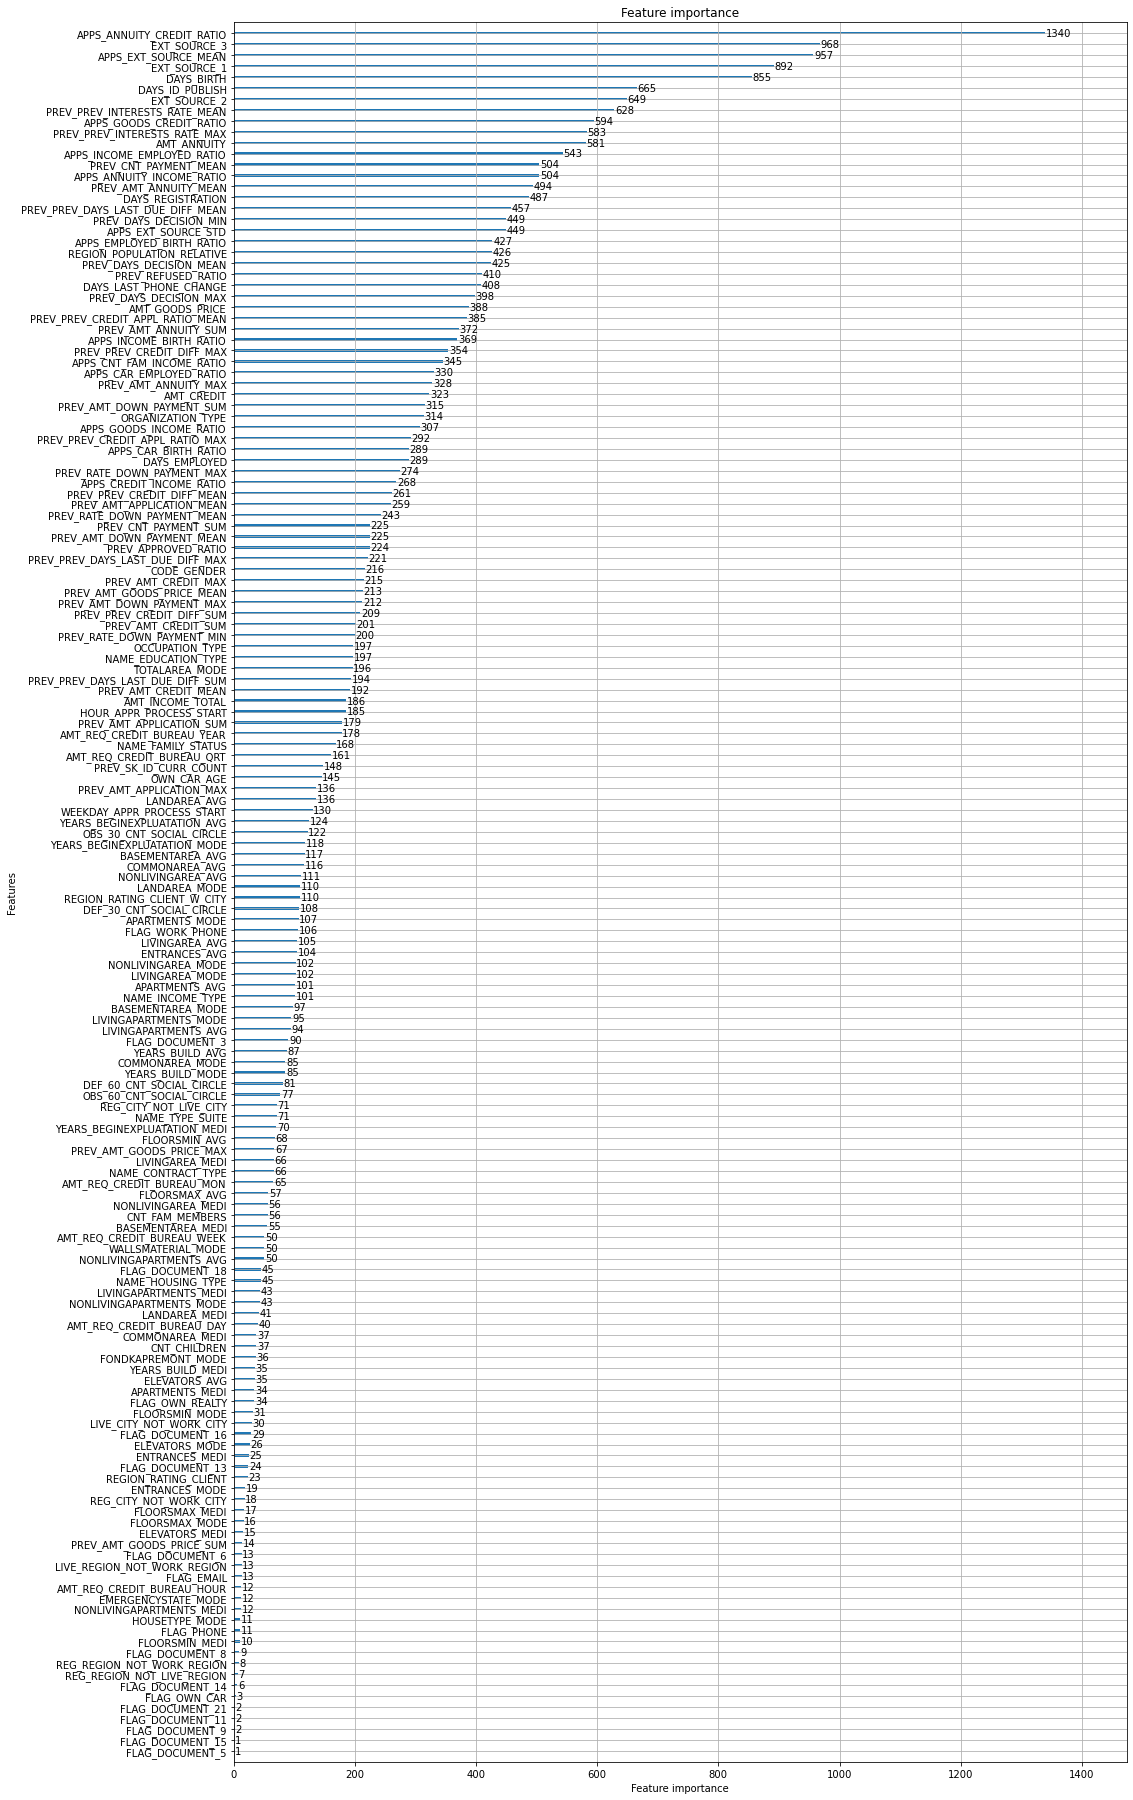

In [218]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

In [220]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1]

In [221]:
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_01.csv', index=False)